## Phone Data

In [48]:
import os
import statistics
import csv
import itertools
import keras
import sklearn.linear_model

import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam

In [49]:
act_path = "wisdm-dataset/activity_key.txt"
act_file = open(act_path,"r")
act_list = act_file.read().split('\n')
act_map = {}
for elem in act_list:
    split = elem.split(" = ")
    if len(split) < 2:
        continue
    act_map[split[1]] = split[0]
    
act_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [50]:
phone = pd.read_pickle('phone.df')

In [51]:
window_size = 100
stride = window_size

frames = []
for i in tqdm(range(0, len(phone)-window_size, stride)):
    window = phone.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
        frames.append(window)

In [52]:
activities = sorted(act_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

for frame in tqdm(frames):
    X_list.append(frame[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])

In [53]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [54]:
print(X.shape)
print(y.shape)

(46906, 100, 6)
(46906, 18)


sandwich


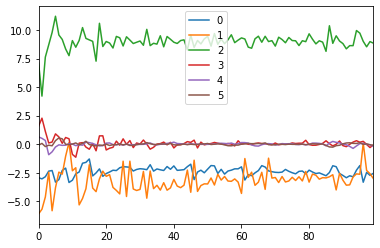

In [55]:
n = 16000
pd.DataFrame(X_list[n]).plot()

reverse_activity_encoding = {v: act_map[k] for k, v in activity_encoding.items()}
print(reverse_activity_encoding[y_list[n]])

In [56]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(28143, 100, 6)
(9381, 100, 6)
(9382, 100, 6)
(28143, 18)
(9381, 18)
(9382, 18)


## LogReg Baseline

In [57]:
lrModel = sklearn.linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
print(X_train_flattened.shape)
lrModel.fit(X_train_flattened, y_train.argmax(axis=1))

(28143, 600)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [61]:
predictions = lrModel.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
score = lrModel.score(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), y_val.argmax(axis=1))
print(score)

0.12013644600788828


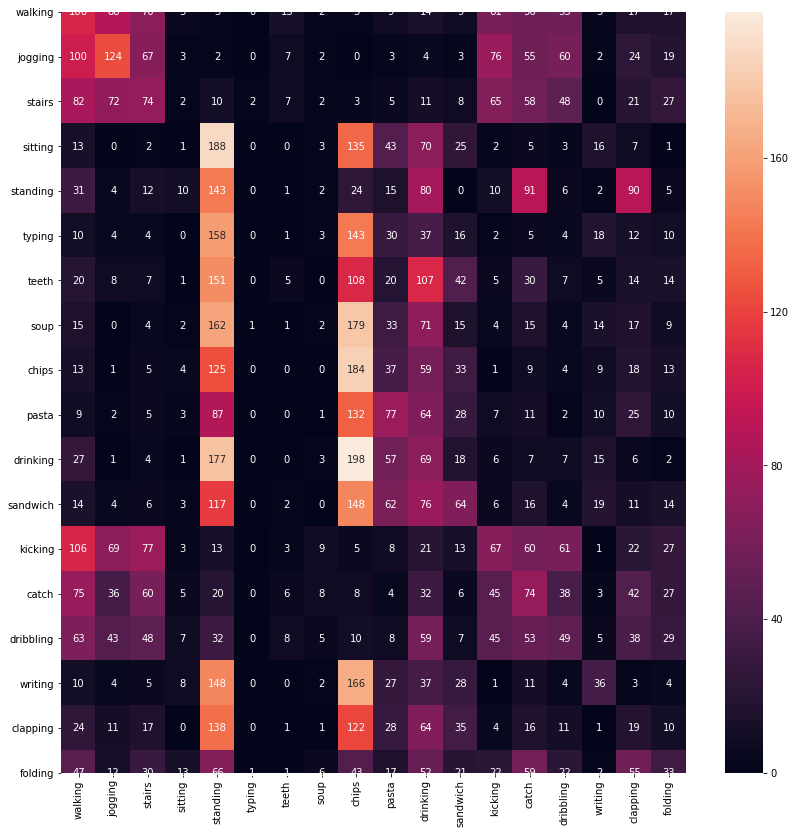

In [63]:
cm = confusion_matrix(y_val.argmax(axis=1), predictions)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True, fmt='g')

In [34]:
model = Sequential()

model.add(Conv1D(8, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# keras.utils.plot_model(
#     model,
#     to_file='model_plot_4-ConvLayer.png',
#     show_shapes=True,
#     show_layer_names=True,
# )

model.summary()



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 98, 8)             152       
_________________________________________________________________
batch_normalization_57 (Batc (None, 98, 8)             32        
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 49, 8)             0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 47, 16)            400       
_________________________________________________________________
batch_normalization_58 (Batc (None, 47, 16)            64        
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 23, 16)            0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 21, 32)          

In [35]:
model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [40]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

Train on 28143 samples, validate on 9381 samples
Epoch 1/20
28143/28143 [==============================] - 6s 206us/step - loss: 1.3126 - acc: 0.5302 - val_loss: 1.4256 - val_acc: 0.5092
Epoch 2/20
28143/28143 [==============================] - 6s 202us/step - loss: 1.3067 - acc: 0.5274 - val_loss: 1.4539 - val_acc: 0.4983
Epoch 3/20
28143/28143 [==============================] - 6s 206us/step - loss: 1.3031 - acc: 0.5323 - val_loss: 1.4134 - val_acc: 0.5170
Epoch 4/20
28143/28143 [==============================] - 6s 211us/step - loss: 1.2945 - acc: 0.5327 - val_loss: 1.4254 - val_acc: 0.5130
Epoch 5/20
28143/28143 [==============================] - 6s 203us/step - loss: 1.2865 - acc: 0.5383 - val_loss: 1.4043 - val_acc: 0.5304
Epoch 6/20
28143/28143 [==============================] - 5s 195us/step - loss: 1.2703 - acc: 0.5443 - val_loss: 1.4287 - val_acc: 0.5188
Epoch 7/20
28143/28143 [==============================] - 5s 194us/step - loss: 1.2572 - acc: 0.5478 - val_loss: 1.4318 - v

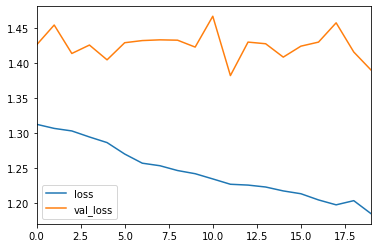

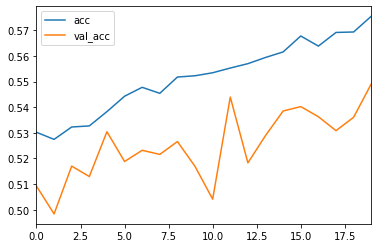

In [46]:
metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

In [37]:
y_val_pred = model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = y_val_pred.argmax(axis=1)

actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

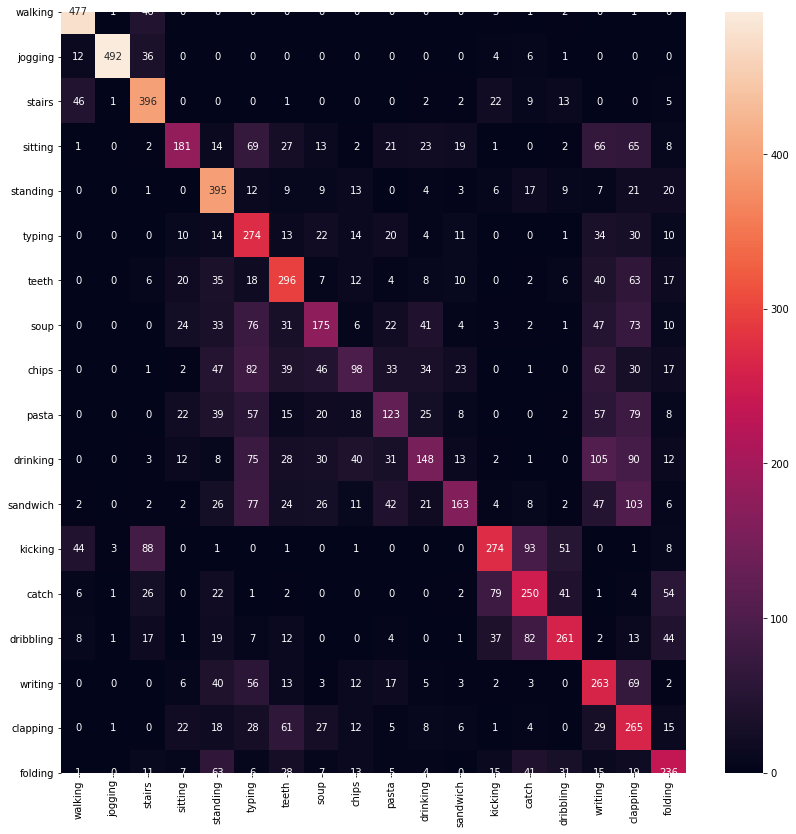

In [45]:
cm = confusion_matrix(y_val_argmax, y_val_pred_argmax)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True, fmt='g')